### Connect to Drive

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/My Drive

/gdrive/My Drive


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import cv2 
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import tensorflow_datasets as tfds

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.11.0


### Set seed for reproducibility

In [7]:
# Random seed for reproducibility
seed = 99

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [8]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Import Data



In [9]:
#Split Train and test
train_ds= tfk.preprocessing.image_dataset_from_directory(
    directory='training_data_final',
    labels='inferred',
    label_mode='categorical',
    batch_size=100000,
    image_size=(96, 96),
    validation_split=0.1,
    subset="training", 
    seed=99)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='training_data_final',
    labels='inferred',
    label_mode='categorical',
    batch_size=100000,
    image_size=(96, 96),
    validation_split=0.1,
    subset="validation",
    seed=99)


Found 3542 files belonging to 8 classes.
Using 3188 files for training.
Found 3542 files belonging to 8 classes.
Using 354 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']


In [11]:
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4', 4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

In [12]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [13]:
X_train_val = None
Y_train_val = None
for image, label in tfds.as_numpy(train_ds):
  X_train_val = image
  Y_train_val = label
X_train_val.shape, Y_train_val.shape


((3188, 96, 96, 3), (3188, 8))

In [14]:
X_test = None
Y_test = None
for image, label in tfds.as_numpy(test_ds):
  X_test = image
  Y_test = label
X_test.shape, Y_test.shape


((354, 96, 96, 3), (354, 8))

### Process data

In [15]:
# Split in train and test
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, random_state=seed, test_size=.1, stratify=Y_train_val)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((2869, 96, 96, 3), (2869, 8), (319, 96, 96, 3), (319, 8))

In [16]:
# Compare categorical and "default" labels
print('Categorical label:',Y_train[0])
print('"Default" label:',np.argmax(Y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1.]
"Default" label: 7


### Models metadata

In [17]:
input_shape = X_train.shape[1:]
batch_size = 256
epochs = 200
input_shape

(96, 96, 3)

### Standard model

In [18]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Rescaling(scale=1./255., offset=0.0)
    x = tfkl.Resizing(96, 96, interpolation="bicubic", name='resizing')(input_layer)

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'classifier')(x)
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = 8, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 64)        1792      
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 128)       73856     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 24, 24, 256)       295168

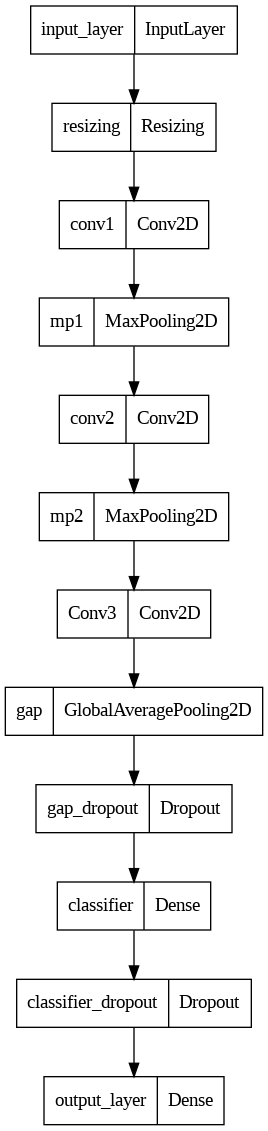

In [19]:
standard_model = build_model(input_shape)
standard_model.summary()
tfk.utils.plot_model(standard_model)

In [20]:
# Train the model
standard_history = standard_model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
12/12 [==============================] - 16s 258ms/step - loss: 115.0331 - accuracy: 0.1405 - val_loss: 5.1964 - val_accuracy: 0.1787
Epoch 2/200
12/12 [==============================] - 2s 201ms/step - loss: 4.2576 - accuracy: 0.1624 - val_loss: 1.8740 - val_accuracy: 0.2508
Epoch 3/200
12/12 [==============================] - 2s 176ms/step - loss: 1.9741 - accuracy: 0.2402 - val_loss: 1.7425 - val_accuracy: 0.3542
Epoch 4/200
12/12 [==============================] - 2s 162ms/step - loss: 1.8277 - accuracy: 0.2959 - val_loss: 1.6125 - val_accuracy: 0.3981
Epoch 5/200
12/12 [==============================] - 2s 157ms/step - loss: 1.7491 - accuracy: 0.3273 - val_loss: 1.6262 - val_accuracy: 0.3793
Epoch 6/200
12/12 [==============================] - 2s 163ms/step - loss: 1.6962 - accuracy: 0.3559 - val_loss: 1.5147 - val_accuracy: 0.4420
Epoch 7/200
12/12 [==============================] - 2s 161ms/step - loss: 1.6504 - accuracy: 0.3517 - val_loss: 1.4671 - val_accuracy: 0.4

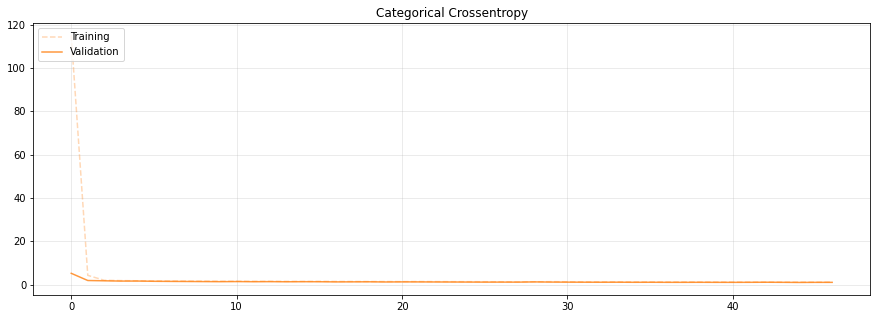

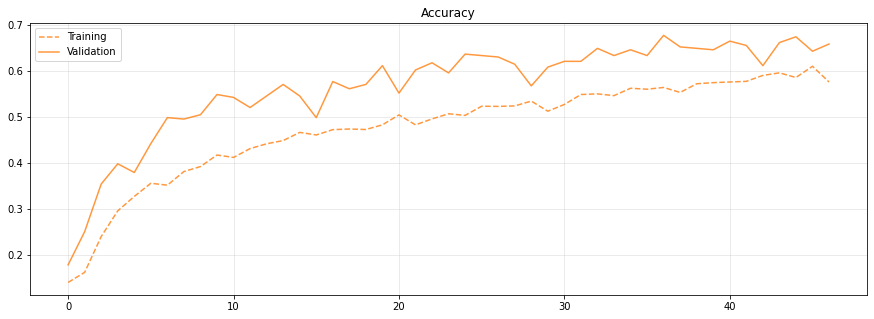

In [21]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [22]:
# Predict the test set with the CNN
predictions = standard_model.predict(X_test)
predictions.shape

12/12 [==============================] - 0s 15ms/step


(354, 8)

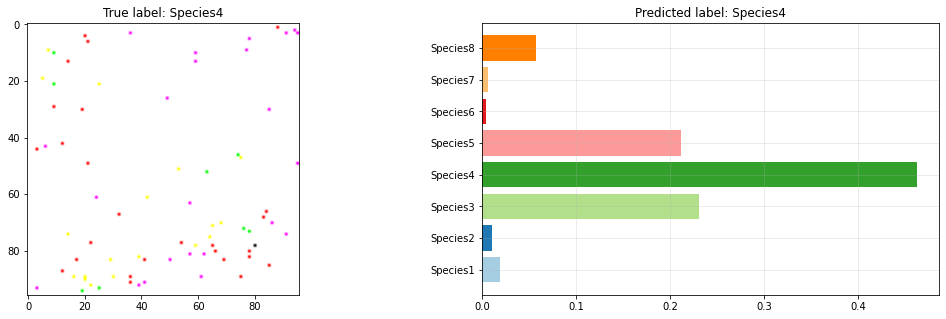

In [23]:
# Plot the target images and the predictions
prediction_index = 100

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(Y_test[prediction_index])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()


Accuracy: 0.5508
Precision: 0.4774
Recall: 0.4977
F1: 0.4795


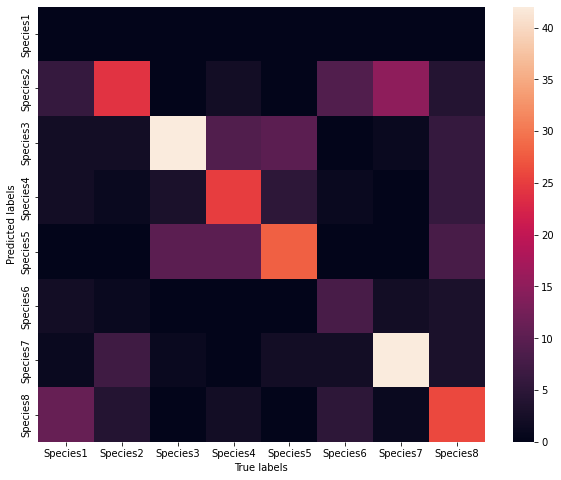

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [25]:
standard_model.save('StandardModel_96x96')
del standard_model

### Transfer learning

In [26]:
# Apply same preprocessing used to train the supernet 
from  tensorflow.keras.applications.vgg16 import preprocess_input

X_train_ft = preprocess_input(X_train*255)
X_val_ft = preprocess_input(X_val*255)
X_test_tf = preprocess_input(X_test*255)

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

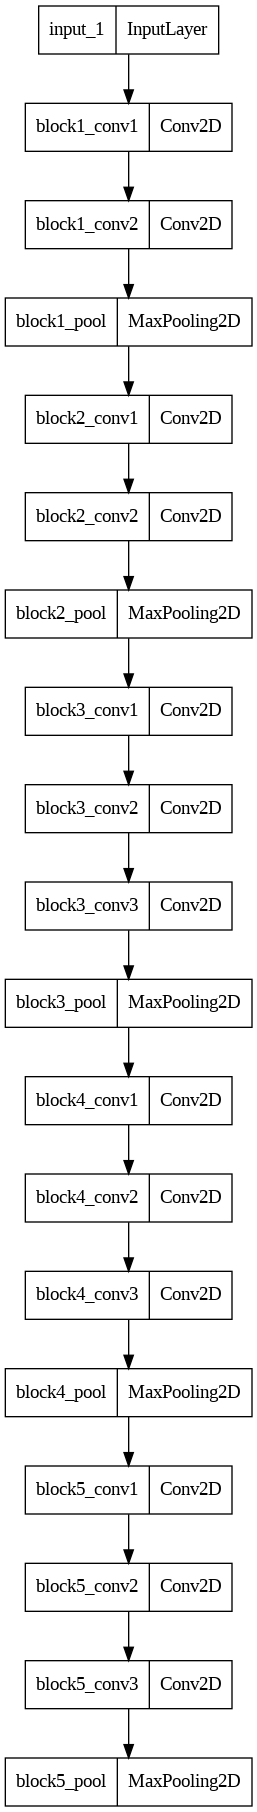

In [27]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [28]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(96, 96, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [29]:
# Train the model
tl_history = tl_model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (X_val_ft, Y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
12/12 [==============================] - 11s 474ms/step - loss: 2346.1338 - accuracy: 0.3475 - val_loss: 611.2224 - val_accuracy: 0.4984
Epoch 2/200
12/12 [==============================] - 3s 233ms/step - loss: 528.5943 - accuracy: 0.5068 - val_loss: 153.4810 - val_accuracy: 0.4984
Epoch 3/200
12/12 [==============================] - 3s 261ms/step - loss: 185.4507 - accuracy: 0.4625 - val_loss: 60.0646 - val_accuracy: 0.4107
Epoch 4/200
12/12 [==============================] - 3s 233ms/step - loss: 78.3400 - accuracy: 0.4036 - val_loss: 21.5114 - val_accuracy: 0.3197
Epoch 5/200
12/12 [==============================] - 3s 232ms/step - loss: 34.8932 - accuracy: 0.3559 - val_loss: 9.5109 - val_accuracy: 0.2320
Epoch 6/200
12/12 [==============================] - 3s 233ms/step - loss: 20.4700 - accuracy: 0.3053 - val_loss: 7.0597 - val_accuracy: 0.2226
Epoch 7/200
12/12 [==============================] - 3s 236ms/step - loss: 13.0060 - accuracy: 0.2952 - val_loss: 5.9947 - va

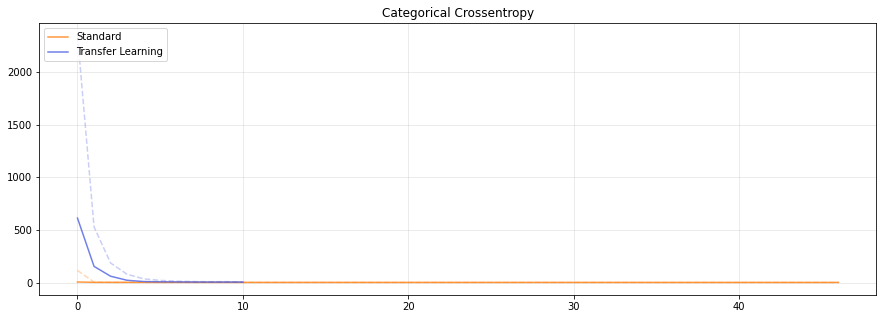

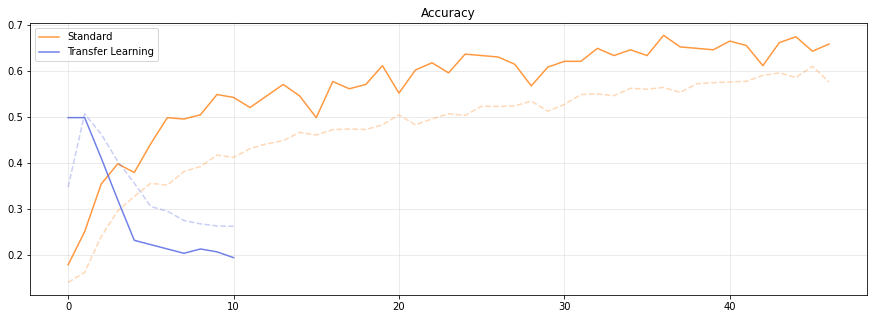

In [30]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set with the CNN
predictions = tl_model.predict(X_test_tf)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

12/12 [==============================] - 1s 52ms/step
Accuracy: 0.6525
Precision: 0.6586
Recall: 0.6104
F1: 0.6073


AttributeError: ignored

<Figure size 720x576 with 0 Axes>

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

###Transfer Learning wit EfficientNetV2S


Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 96, 96, 3)    0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   864         ['rescaling_2[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                   

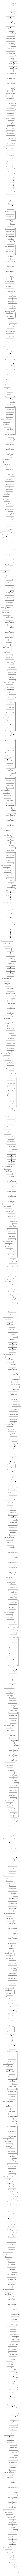

In [ ]:
# Download and plot the EfficientNet B0 model
ENV2l_model = tfk.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# Plot the model
ENV2l_model.summary()
tfk.utils.plot_model(ENV2l_model)

In [ ]:
ENV2l_model.trainable = True

In [ ]:
# Rebuild the classifier
inputs = tfk.Input(shape=input_shape)
x = ENV2l_model(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(96, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.ReLU()(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
model_ENV2l = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model_ENV2l.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
model_ENV2l.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 3, 3, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 96)                122976    
                                                                 
 batch_normalization_1 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                             

In [ ]:
# Freeze the first 100 layers (Fine Tuning)
for i, layer in enumerate(model_ENV2l.get_layer('efficientnetv2-l').layers[: 100]):
  layer.trainable=False

model_ENV2l.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 3, 3, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 96)                122976    
                                                                 
 batch_normalization_1 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                             

In [ ]:
# Compile the model
model_ENV2l.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
model_ENV2l.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 3, 3, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 96)                122976    
                                                                 
 batch_normalization_1 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                             

In [ ]:
# Plot the model
tfk.utils.plot_model(model_ENV2l)

In [ ]:
# Train the model
t2_history = model_ENV2l.fit(
    x = X_train,
    y = Y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (X_val, Y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
12/12 [==============================] - 55s 1s/step - loss: 1.3076 - accuracy: 0.5472 - val_loss: 1.1825 - val_accuracy: 0.6364
Epoch 2/200
12/12 [==============================] - 5s 432ms/step - loss: 0.5008 - accuracy: 0.8310 - val_loss: 0.9626 - val_accuracy: 0.7461
Epoch 3/200
12/12 [==============================] - 5s 425ms/step - loss: 0.2299 - accuracy: 0.9324 - val_loss: 1.0868 - val_accuracy: 0.7680
Epoch 4/200
12/12 [==============================] - 5s 425ms/step - loss: 0.1403 - accuracy: 0.9578 - val_loss: 0.9724 - val_accuracy: 0.7900
Epoch 5/200
12/12 [==============================] - 5s 428ms/step - loss: 0.1021 - accuracy: 0.9728 - val_loss: 0.8270 - val_accuracy: 0.8025
Epoch 6/200
12/12 [==============================] - 5s 420ms/step - loss: 0.0714 - accuracy: 0.9784 - val_loss: 0.7528 - val_accuracy: 0.8339
Epoch 7/200
12/12 [==============================] - 4s 376ms/step - loss: 0.0776 - accuracy: 0.9787 - val_loss: 0.9529 - val_accuracy: 0.7931
E

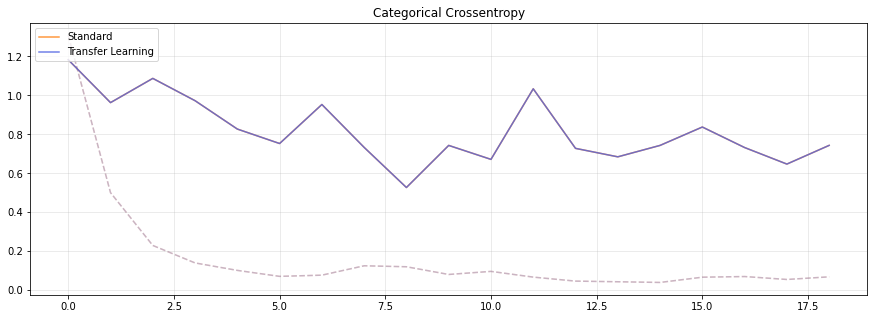

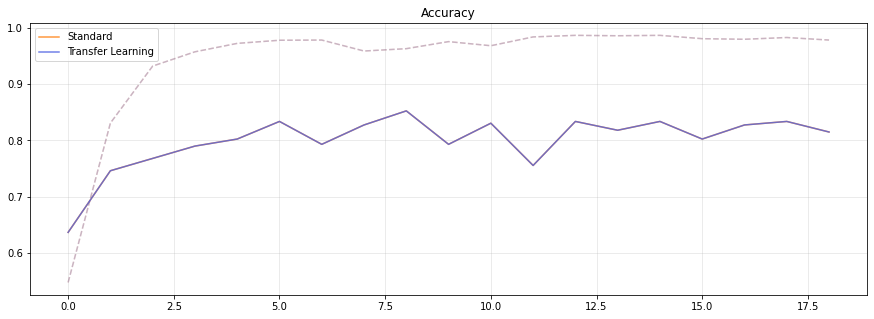

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(t2_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(t2_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(t2_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(t2_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(t2_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(t2_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(t2_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(t2_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set with the CNN
predictions_3 = model_ENV2l.predict(X_test)
predictions_3.shape

12/12 [==============================] - 7s 71ms/step


(354, 8)

Accuracy: 0.8079
Precision: 0.7933
Recall: 0.7739
F1: 0.7774


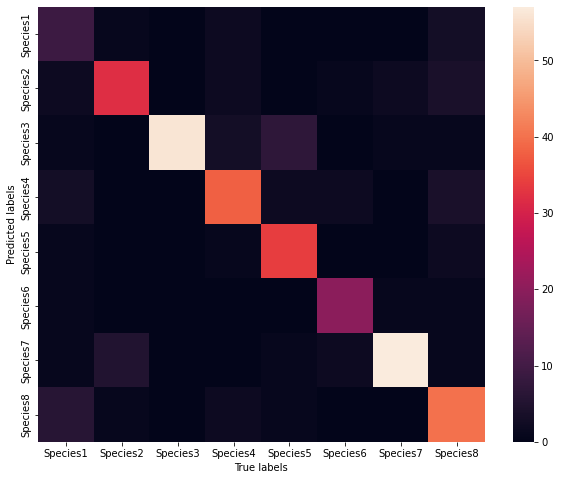

In [ ]:
# Compute the confusion matrix
cm_2 = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions_3, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_3, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_3, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_3, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_3, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_2.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Save the best model
model_ENV2l.save('ENV2lModel')
del model_ENV2l

###Transfer Learning with EfficientNet

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 96, 96, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 96, 96, 3)    0           ['normalization[0][0]']          
                    

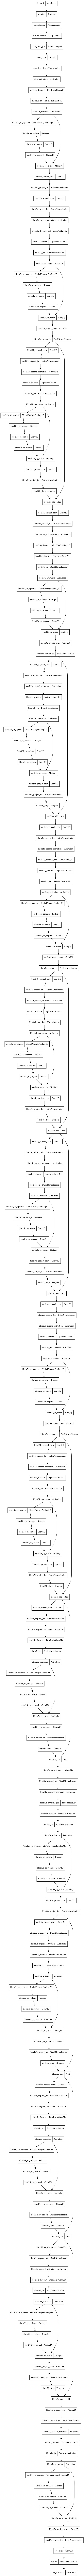

In [ ]:
# Download and plot the EfficientNet B0 model
base_model = tfk.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# Plot the model
base_model.summary()
tfk.utils.plot_model(base_model)

In [ ]:
base_model.trainable = True

In [ ]:
# Rebuild the classifier
inputs = tfk.Input(shape=input_shape)
x = base_model(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(96, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.ReLU()(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
model_t2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model_t2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
model_t2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 96)                122976    
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 96)                0     

In [ ]:
# Freeze the first 100 layers (Fine Tuning)
for i, layer in enumerate(model_t2.get_layer('efficientnetb0').layers[: 100]):
  layer.trainable=False

model_t2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 96)                122976    
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 96)                0     

In [ ]:
# Compile the model
model_t2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
model_t2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 96)                122976    
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 96)                0     

In [ ]:
X_val.shape, Y_val.shape

((319, 96, 96, 3), (319, 8))

In [ ]:
# Train the model
t2_history = model_t2.fit(
    x = X_train,
    y = Y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (X_val, Y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
12/12 [==============================] - 21s 255ms/step - loss: 1.4908 - accuracy: 0.4594 - val_loss: 1.3972 - val_accuracy: 0.5016
Epoch 2/200
12/12 [==============================] - 1s 77ms/step - loss: 0.5479 - accuracy: 0.8438 - val_loss: 1.1715 - val_accuracy: 0.5674
Epoch 3/200
12/12 [==============================] - 1s 77ms/step - loss: 0.2866 - accuracy: 0.9240 - val_loss: 1.1838 - val_accuracy: 0.5987
Epoch 4/200
12/12 [==============================] - 1s 69ms/step - loss: 0.1414 - accuracy: 0.9763 - val_loss: 1.2042 - val_accuracy: 0.5925
Epoch 5/200
12/12 [==============================] - 1s 76ms/step - loss: 0.0768 - accuracy: 0.9906 - val_loss: 1.0343 - val_accuracy: 0.6207
Epoch 6/200
12/12 [==============================] - 1s 75ms/step - loss: 0.0553 - accuracy: 0.9913 - val_loss: 0.9330 - val_accuracy: 0.6708
Epoch 7/200
12/12 [==============================] - 1s 77ms/step - loss: 0.0427 - accuracy: 0.9927 - val_loss: 0.9069 - val_accuracy: 0.7147
Epoc

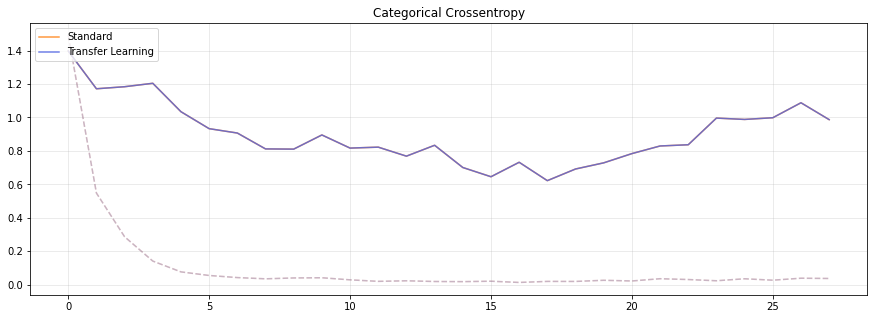

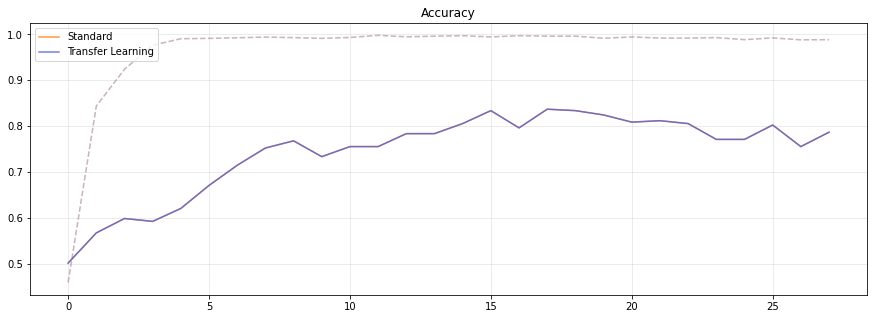

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(t2_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(t2_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(t2_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(t2_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(t2_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(t2_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(t2_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(t2_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set with the CNN
predictions_2 = model_t2.predict(X_test)
predictions_2.shape

12/12 [==============================] - 2s 24ms/step


(354, 8)

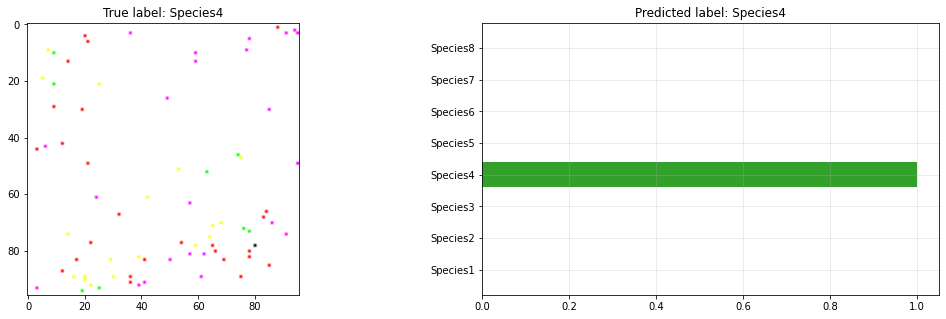

In [ ]:
# Plot the target images and the predictions
prediction_index = 100

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(Y_test[prediction_index])])
ax2.barh(list(labels.values()), predictions_2[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions_2[prediction_index])])
ax2.grid(alpha=.3)
plt.show()


Accuracy: 0.774
Precision: 0.7489
Recall: 0.7351
F1: 0.7361


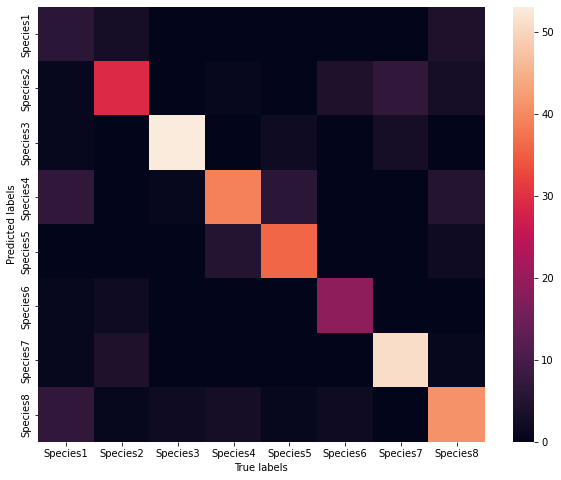

In [ ]:
# Compute the confusion matrix
cm_2 = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_2.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Save the best model
model_t2.save('TLModel')
del model_t2

### Fine tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 96)                122976    
                                                                 
 batch_normalization_1 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 96)                0     

In [ ]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (X_val_ft, Y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set with the CNN
predictions = ft_model.predict(X_test_tf)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.save('FineTuningModel')
del ft_model

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Resizing(96, 96, interpolation="bicubic", name='resizing')(input_layer)

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(x)
    x = tfkl.BatchNormalization(name='Bn1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    x = tfkl.BatchNormalization(name='Bn2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    x = tfkl.BatchNormalization(name='Bn3')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'classifier')(x)
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = 8, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
standard_model_2 = build_model(input_shape)
standard_model_2.summary()
tfk.utils.plot_model(standard_model_2)

In [ ]:
# Train the model
standard_history = standard_model_2.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set with the CNN
predictions_2 = standard_model_2.predict(X_test)
predictions_2.shape

In [ ]:
# Plot the target images and the predictions
prediction_index = 100

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(Y_test[prediction_index])])
ax2.barh(list(labels.values()), predictions_2[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions_2[prediction_index])])
ax2.grid(alpha=.3)
plt.show()


In [ ]:
# Compute the confusion matrix
cm_2 = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_2.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
standard_model.save('StandardModel_96x96')
del standard_model